In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm
from tensorly.base import unfold

import tensor_utils as utils

np.random.seed(14159)

In [2]:
d = 3
z = 1+1j
frobH = 10
R = 30
T = 50

c = np.random.uniform(0, 1, d)
c /= np.sum(c)
r = np.round(c*R).astype(int)
Nr = np.linspace(50, 500, T).astype(int)

In [3]:
def init(n, r, frobH):
    H = np.random.randn(*r)
    H = frobH*H/utils.frob(H)
    X = [linalg.orth(np.random.randn(n_, r_)) for (n_, r_) in zip(n, r)]
    Z = np.random.randn(*n)
    P = utils.tucker_prod(H, X)
    T = P+Z/np.sqrt(np.sum(n))
    return T, P, Z

In [4]:
def m(z, c, N, d, i):
    Em, Ep = (np.sqrt(c[i])-np.sqrt(np.prod(c)*(N**(d-2))))**2, (np.sqrt(c[i])+np.sqrt(np.prod(c)*(N**(d-2))))**2
    Delta = (Em-z)*(Ep-z)
    m = (-(z+c[i]-np.prod(c)*(N**(d-2)))+np.sqrt(Delta))/(2*z*c[i])
    if m.imag < 0:
        m = np.conj(m)
    return m

In [5]:
tr = np.zeros((T, d), dtype=complex)
prod = np.zeros((T, d), dtype=complex)

In [6]:
for t in tqdm(range(T)):
    n = np.round(Nr[t]*c).astype(int)
    T, P, Z = init(n, r, frobH)
    for i in range(d):
        Ti = unfold(T, i)
        Pi = unfold(P, i)
        Qi = linalg.inv(Ti@Ti.T-z*np.eye(n[i]))
        mz = m(z, c, Nr[t], d, i)
        A = np.random.randn(n[i], n[i])
        A /= linalg.norm(A, ord=2)
        a, b = np.random.randn(n[i]), np.random.randn(n[i])
        a, b = a/linalg.norm(a, ord=2), b/linalg.norm(b, ord=2)
        diff = Pi@Ti.T@Qi-Pi@Pi.T@Qi/(1+c[i]*mz)
        tr[t, i] = np.trace(A@diff)/n[i]
        prod[t, i] = a@diff@b

100%|██████████| 50/50 [07:56<00:00,  9.53s/it]


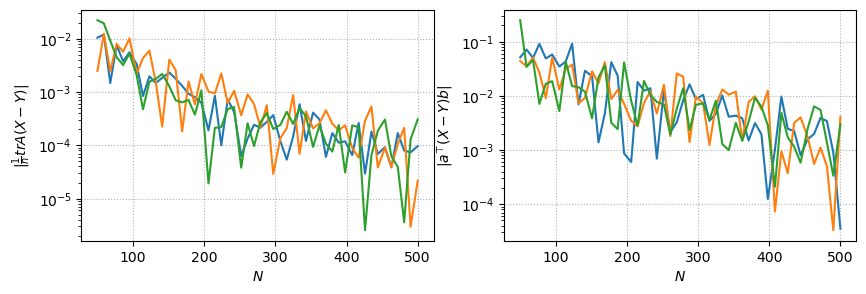

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(Nr, np.abs(tr))
ax[0].set_yscale('log')
ax[0].grid(ls=':')
ax[0].set_xlabel("$N$");
ax[0].set_ylabel("$| \\frac{1}{n} tr A ( X - Y ) |$");
ax[1].plot(Nr, np.abs(prod))
ax[1].set_yscale('log')
ax[1].grid(ls=':')
ax[1].set_xlabel("$N$");
ax[1].set_ylabel("$| a^\\top ( X - Y ) b |$");